# Dataset ARE

In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, TimeDistributed, Flatten, Conv1D

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARE-Historical-Data-final.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# Xây dựng mô hình TDNN
window_size = 1

model = Sequential()
model.add(InputLayer(input_shape=(window_size, 1)))  # Kích thước đầu vào: (số thời điểm, số đặc trưng)
model.add(TimeDistributed(Dense(64, activation='relu')))  # Lớp TimeDistributed với lớp Dense 64 đơn vị và hàm kích hoạt ReLU
model.add(TimeDistributed(Dense(32, activation='relu')))  # Lớp TimeDistributed với lớp Dense 32 đơn vị và hàm kích hoạt ReLU
model.add(Flatten())  # Dùng để làm phẳng dữ liệu đầu ra từ các lớp TimeDistributed
model.add(Dense(1))

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 1s 10ms/step - loss: 0.0423 - val_loss: 0.0704
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0136
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0117
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0062
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 6.7117e-04 - val_loss: 0.0043
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 2.9580e-04 - val_loss: 0.0031
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 1.2357e-04 - val_loss: 0.0020
Epoch 8/100
20/20 [==============================] - 0s 6ms/step - loss: 9.7641e-05 - val_loss: 0.0016
Epoch 9/100
20/20 [==============================] - 0s 6ms/step - loss: 9.3400e-05 - val_loss: 0.0015
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 9.1442e-05 - v

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)


In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
valid_mape = np.mean(np.abs((y_pred_val - yval) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 6.350275603625121
Testing RMSE: 5.350049628926732
Testing MAE: 4.047339978229352
Validation MAE: 4.648712487074908
Testing MAPE: 2.3238651120303286
Validation MAPE: 2.5792350982540833


In [ ]:
# Dự báo 7 ngày tiếp theo
x_input = val_data[-1:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 1
i = 0

while i < 7:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

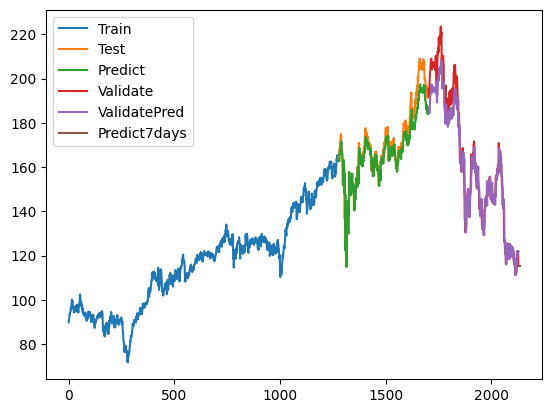

In [ ]:
# # 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

In [ ]:
scaler.inverse_transform(lst_output)

array([[115.38827521],
       [115.38827521],
       [115.38827521],
       [115.38827521],
       [115.38827521],
       [115.38827521],
       [115.38827521]])

# Dataset ARI

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARI-Historical-Data-final.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# Xây dựng mô hình TDNN
window_size = 1

model = Sequential()
model.add(InputLayer(input_shape=(window_size, 1)))  # Kích thước đầu vào: (số thời điểm, số đặc trưng)
model.add(TimeDistributed(Dense(64, activation='relu')))  # Lớp TimeDistributed với lớp Dense 64 đơn vị và hàm kích hoạt ReLU
model.add(TimeDistributed(Dense(32, activation='relu')))  # Lớp TimeDistributed với lớp Dense 32 đơn vị và hàm kích hoạt ReLU
model.add(Flatten())  # Dùng để làm phẳng dữ liệu đầu ra từ các lớp TimeDistributed
model.add(Dense(1))

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 1s 15ms/step - loss: 0.2284 - val_loss: 0.0092
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0078 - val_loss: 0.0214
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0085
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 5.4145e-04 - val_loss: 0.0090
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 3.2737e-04 - val_loss: 0.0098
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 3.0217e-04 - val_loss: 0.0091
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 3.0225e-04 - val_loss: 0.0093
Epoch 8/100
20/20 [==============================] - 0s 6ms/step - loss: 2.9961e-04 - val_loss: 0.0092
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 2.9741e-04 - val_loss: 0.0091
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 2.9549e-04

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
valid_mape = np.mean(np.abs((y_pred_val - yval) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.3603648610570692
Testing RMSE: 0.5262394102416357
Testing MAE: 0.3522833558120908
Validation MAE: 0.27689859861486077
Testing MAPE: 3.626822260922477
Validation MAPE: 2.476022724654236


In [ ]:
# Dự báo 7 ngày tiếp theo
x_input = val_data[-1:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 1
i = 0

while i < 7:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

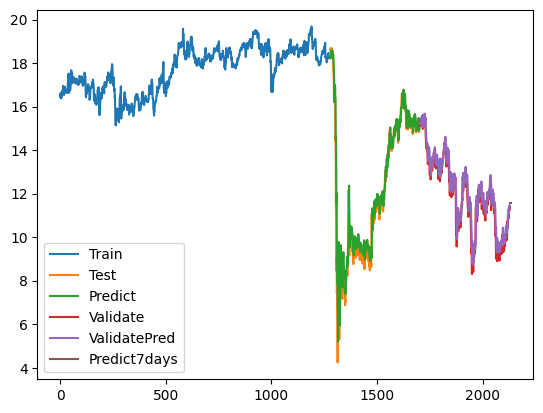

In [ ]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

In [ ]:
scaler.inverse_transform(lst_output)

array([[11.55607899],
       [11.55607899],
       [11.55607899],
       [11.55607899],
       [11.55607899],
       [11.55607899],
       [11.55607899]])

# Dataset MAA

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('MAA-Historical-Data-final.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# Xây dựng mô hình TDNN
window_size = 1

model = Sequential()
model.add(InputLayer(input_shape=(window_size, 1)))  # Kích thước đầu vào: (số thời điểm, số đặc trưng)
model.add(TimeDistributed(Dense(64, activation='relu')))  # Lớp TimeDistributed với lớp Dense 64 đơn vị và hàm kích hoạt ReLU
model.add(TimeDistributed(Dense(32, activation='relu')))  # Lớp TimeDistributed với lớp Dense 32 đơn vị và hàm kích hoạt ReLU
model.add(Flatten())  # Dùng để làm phẳng dữ liệu đầu ra từ các lớp TimeDistributed
model.add(Dense(1))

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 1s 12ms/step - loss: 0.0145 - val_loss: 0.0336
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0136
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0087
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 5.1365e-04 - val_loss: 0.0050
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 1.6753e-04 - val_loss: 0.0027
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 6.4636e-05 - val_loss: 0.0018
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 5.2765e-05 - val_loss: 0.0015
Epoch 8/100
20/20 [==============================] - 0s 6ms/step - loss: 5.1926e-05 - val_loss: 0.0014
Epoch 9/100
20/20 [==============================] - 0s 6ms/step - loss: 5.0931e-05 - val_loss: 0.0014
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 5.1512e-05

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 1ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
valid_mape = np.mean(np.abs((y_pred_val - yval) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 11.213391578448238
Testing RMSE: 5.940431632944288
Testing MAE: 4.193847765189817
Validation MAE: 9.43839295869715
Testing MAPE: 2.768476200231907
Validation MAPE: 4.986236977065409


In [ ]:
# Dự báo 7 ngày tiếp theo
x_input = val_data[-1:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 1
i = 0

while i < 7:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

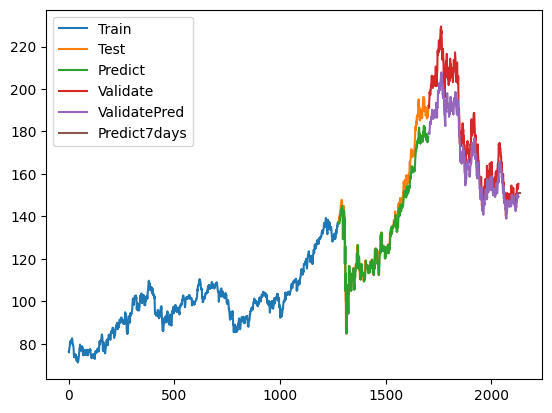

In [ ]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

In [ ]:
scaler.inverse_transform(lst_output)

array([[150.85456026],
       [150.85456026],
       [150.85456026],
       [150.85456026],
       [150.85456026],
       [150.85456026],
       [150.85456026]])